#**DCGAN - Unsupervised Representation Learning With Deep Convolution Generative Adversarial Networks**

In this project, I have implemented the DCGAN Model. It is the most basic version of GAN with simple architecture(Few Convolution layers for discriminator and Upsampling or ConvTranspose layers for Generator)

**Original GAN Paper** : [GAN](https://arxiv.org/pdf/1406.2661.pdf)

**Deep Convolution GAN Paper** : [DCGAN](https://arxiv.org/pdf/1511.06434.pdf)

**Dataset Download** : [Celeb Faces](https://www.kaggle.com/jessicali9530/celeba-dataset)

**Special Note**

All file paths used below as specific to my system. Please change them accordingly if you are using the code as it is.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
from torchvision.utils import make_grid

import os
from torchvision.utils import save_image
import glob
import math 
import gc
import time
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## **Downloading and Loading the data**

In [ ]:
batch_size = 128
latent_size = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!pip install kaggle
%env KAGGLE_USERNAME= adityavaichalkar
%env KAGGLE_KEY= 846001b07ef067aa289f5fc93aa580c5
%cd "/content/drive/Mydrive"   
!kaggle datasets download -d jessicali9530/celeba-dataset 
!unzip "/content/celeba-dataset.zip"      # Change the folder name accordingly if you save the images in your drive

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [ ]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class Dataload(Dataset):
    def __init__(self, transform = True):
        self.transforms = transform
        self.train_image = []
        self.train_image = sorted(glob.glob(os.path.join('/content/img_align_celeba/img_align_celeba', '*.jpg')))
        if transform:
            self._init_transform()

    def _init_transform(self):
        imageSize=64
        self.transform = transforms.Compose([
        # Useful link for this part: https://pytorch.org/vision/stable/transforms.html
        #----------------YOUR CODE HERE---------------------#
        transforms.Resize(imageSize),
        transforms.CenterCrop(imageSize),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        

    def __getitem__(self, index):
        img = pil_loader(self.train_image[index])
        if self.transforms:
            img = self.transform(img)
        return img

    def __len__(self):
        return len(self.train_image)

train_dataset = Dataload()
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 2, drop_last=True)

## **Generative Adversarial Networks - DCGAN**

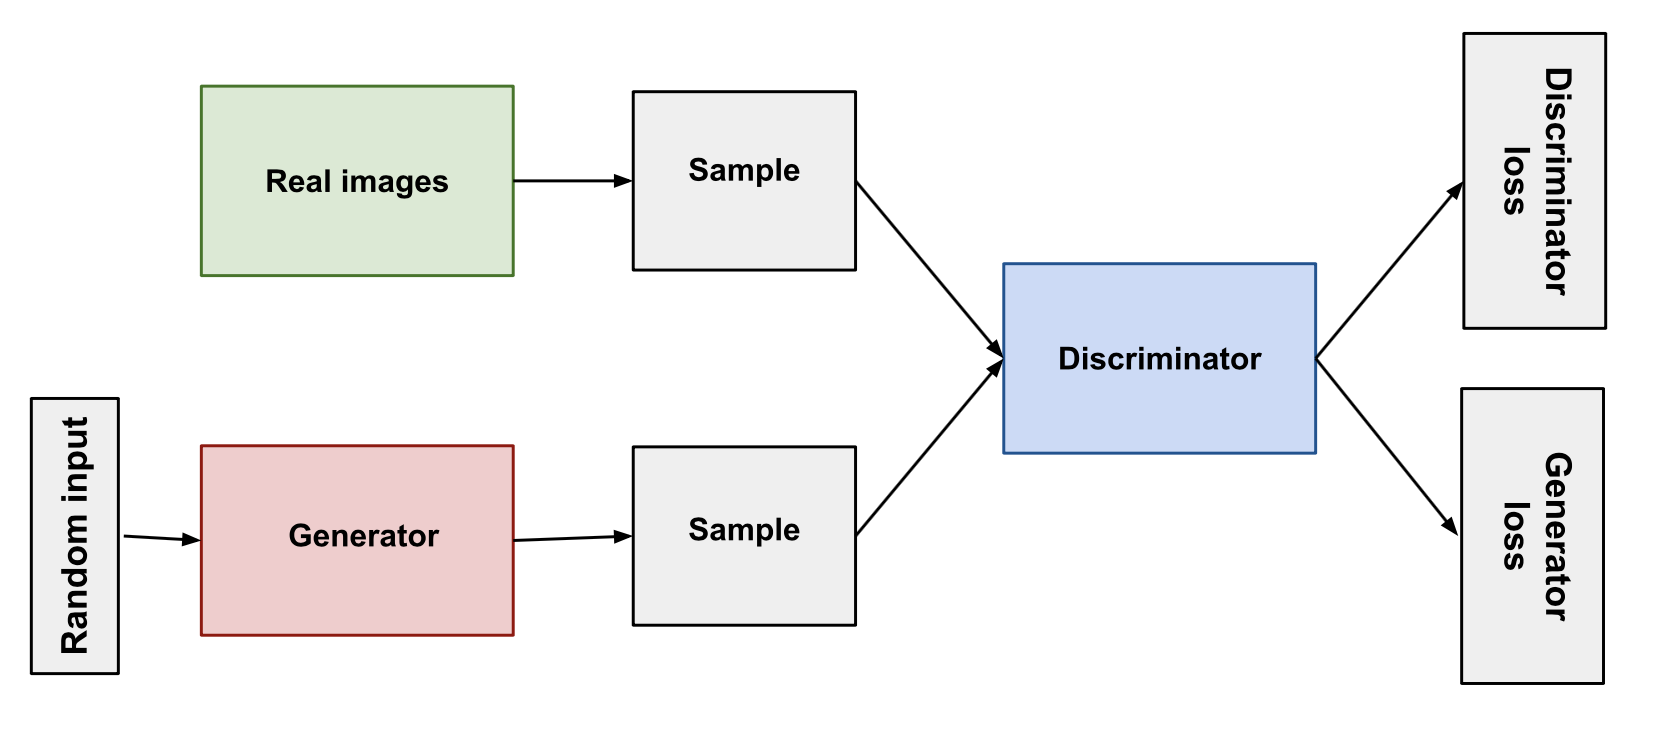

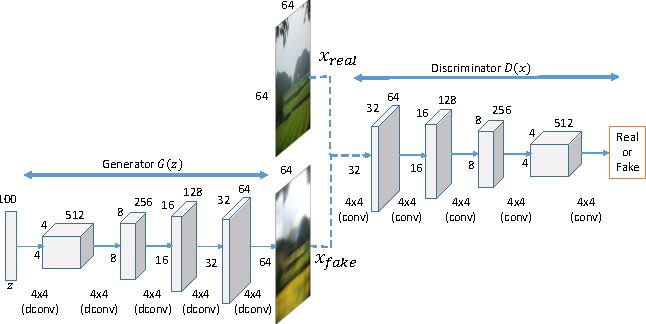

In [ ]:
# Initialising the weights for the generator and discriminator for stable training 

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self,noise=100,channels=3,features=64):
        super(Generator, self).__init__()

        self.gen = nn.Sequential(

        # Useful Link: https://pytorch.org/docs/stable/nn.html
        #------------ENTER YOUR MODEL HERE----------------#   
            nn.ConvTranspose2d(noise, features * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(features * 8, features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(features * 4, features* 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(features * 2,     features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(features,channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.to(device)
        return self.gen(x)


generator = Generator()

generator.to(device)

generator.apply(weights_init)

def get_model_summary(model, input_tensor_shape):
    summary(generator.to(device), input_tensor_shape)
get_model_summary(generator, (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [ ]:
class Discriminator(nn.Module):
    def __init__(self,channels=3,features=64):
        super(Discriminator, self).__init__()

        self.dis = nn.Sequential(

        # Useful Link: https://pytorch.org/docs/stable/nn.html
        #------------ENTER YOUR MODEL HERE----------------#
            nn.Conv2d(channels, features, 4, 2, 1, bias=False),#padding=1, kernel=4 ,stride=2 gives half the width and height
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(features, features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(features * 2, features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(features * 4, features * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.to(device)
        return self.dis(x)

discriminator = Discriminator()

discriminator.to(device)

discriminator.apply(weights_init)

def get_model_summary(model, input_tensor_shape):
    summary(discriminator.to(device), input_tensor_shape)
get_model_summary(discriminator, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

## **Training**

In [ ]:
epoch_Dlosses = []             
epoch_Glosses = []
epoch_Real_Score = []
epoch_Fake_Score = []
epoch_Generator_Score = []

In [ ]:
epochs = 5
#------------YOUR CODE HERE----------------#
# Define the learning rate and optimizer 
# GANs are very sensitive to hyperparameters so set your learning rate accordingly

lr = 0.0002
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
#------------------------------------------#

# Loading the checkpoints if you need to continue from where you left

''' Uncomment the below part to load the checkpoints if you have saved already'''
# checkpoint = torch.load('/content/drive/MyDrive/generator_GANS_Celeb.pt')
# generator.load_state_dict(checkpoint['model_state_dict'])
# generator.to(device)
# optimizerG.load_state_dict(checkpoint['optimizer_state_dict'])

# checkpoint = torch.load('/content/drive/MyDrive/discriminator_GANS_Celeb.pt')
# discriminator.load_state_dict(checkpoint['model_state_dict'])
# discriminator.to(device)
# optimizerD.load_state_dict(checkpoint['optimizer_state_dict'])


# Defining the Train function for Generator and Discriminator

def train_discriminator(real_images, optimizer):
    optimizer.zero_grad()

    real_images = real_images.to(device)
    real_pred = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0),1,1,1)
    real_pred = real_pred.to(device)
    real_targets = real_targets.to(device)
    real_loss = F.binary_cross_entropy(real_pred, real_targets)
    real_score = torch.mean(real_pred).item()
    z = torch.randn(batch_size, latent_size, 1, 1)
    z = z.to(device)
    fake_images = generator(z)
    fake_pred = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0),1,1,1)
    fake_pred = fake_pred.to(device)
    fake_targets = fake_targets.to(device)
    fake_loss = F.binary_cross_entropy(fake_pred, fake_targets)
    fake_score = torch.mean(fake_pred).item()

    discriminator_loss = fake_loss + real_loss
    discriminator_loss.backward()
    optimizer.step()

    return discriminator_loss.item(), real_score, fake_score


def train_generator(optimizer):

    optimizer.zero_grad()

    z = torch.randn(batch_size, latent_size, 1, 1)
    z = z.to(device)
    generator_images = generator(z)
    generator_pred = discriminator(generator_images)
    generator_targets = torch.ones(batch_size, 1,1,1)
    generator_pred = generator_pred.to(device)
    generator_targets = generator_targets.to(device)
    generator_loss = F.binary_cross_entropy(generator_pred, generator_targets)
    generator_score = torch.mean(generator_pred).item()

    generator_loss.backward()
    optimizer.step()

    return generator_loss.item(), generator_score


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# To save the images so as to keep a progress of the learning of Generator

sample_dir = '/content/drive/MyDrive/GAN Images/CelebA'
os.makedirs(sample_dir, exist_ok=True)
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

def save_samples(index1, index2, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{}-{}.png'.format(index1, index2)
    save_image((fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

# TRAINING

for epoch in range(epochs):
    
    start_time = time.monotonic()
    
    print(f"Epoch: {epoch + 1}")
    train_DLoss_batch = []
    train_GLoss_batch = []
    train_real_score = []
    train_fake_score = []
    train_generator_score = []

    for idx,(real_images) in enumerate(train_dataloader):
        discriminator_loss, real_score, fake_score = train_discriminator(real_images, optimizerD)
        generator_loss, generator_score = train_generator(optimizerG)
        train_DLoss_batch.append(discriminator_loss)
        train_GLoss_batch.append(generator_loss)
        train_real_score.append(real_score)
        train_fake_score.append(fake_score)
        train_generator_score.append(generator_score)
        if (idx+1)%100 == 0:
            print(f"Epoch [{(idx+1)//100}/15] Discriminator Batch Loss: {discriminator_loss:.5f}   Generator Batch Loss: {generator_loss:.5f}   Real Score: {real_score:.5f}   Fake Score: {fake_score}   Genrator Score: {generator_score:.5f}")
            save_samples(epoch+1, int((idx+1)//100), fixed_latent, show=False)

    epoch_Dlosses.append(sum(train_DLoss_batch)/len(train_dataloader))
    epoch_Glosses.append(sum(train_GLoss_batch)/len(train_dataloader))
    epoch_Real_Score.append(sum(train_real_score)/len(train_dataloader))
    epoch_Fake_Score.append(sum(train_fake_score)/len(train_dataloader))
    epoch_Generator_Score.append(sum(train_generator_score)/len(train_dataloader))

    # Saving the Generator and Discriminator weights 
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': discriminator.state_dict(),
        'optimizer_state_dict': optimizerD.state_dict(),
        'loss': epoch_Dlosses[-1],
        }, '/content/drive/MyDrive/discriminator_GANS_Celeb.pt')

    torch.save({
        'epoch': epoch,
        'model_state_dict': generator.state_dict(),
        'optimizer_state_dict': optimizerG.state_dict(),
        'loss': epoch_Glosses[-1],
        }, '/content/drive/MyDrive/generator_GANS_Celeb.pt')

    print(f"Epoch {epoch + 1} Training Over")
    print(f"Discriminator Epoch Loss: {epoch_Dlosses[-1]:.5f}   Generator Epoch Loss: {epoch_Glosses[-1]:.5f}   Real Score: {epoch_Real_Score[-1]:.5f}   Fake Score: {epoch_Fake_Score[-1]:.5f}   Generator Score: {epoch_Generator_Score[-1]:.5f}")

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()
    gc.collect()
    print("\n\n\n TIME TAKEN FOR THE EPOCH: {} mins and {} seconds".format(epoch_mins, epoch_secs))
    

print("OVERALL TRAINING COMPLETE")

Epoch: 1
Epoch [1/15] Discriminator Batch Loss: 0.38795   Generator Batch Loss: 9.85888   Real Score: 0.94646   Fake Score: 0.2273329198360443   Genrator Score: 0.00025
Epoch [2/15] Discriminator Batch Loss: 0.34737   Generator Batch Loss: 6.13697   Real Score: 0.87043   Fake Score: 0.13917037844657898   Genrator Score: 0.00457
Epoch [3/15] Discriminator Batch Loss: 0.32390   Generator Batch Loss: 3.72258   Real Score: 0.80484   Fake Score: 0.05730632692575455   Genrator Score: 0.03584
Epoch [4/15] Discriminator Batch Loss: 1.13443   Generator Batch Loss: 2.25174   Real Score: 0.46475   Fake Score: 0.025713235139846802   Genrator Score: 0.15145
Epoch [5/15] Discriminator Batch Loss: 0.36357   Generator Batch Loss: 4.66450   Real Score: 0.94664   Fake Score: 0.23492106795310974   Genrator Score: 0.02352
Epoch [6/15] Discriminator Batch Loss: 0.40560   Generator Batch Loss: 5.97709   Real Score: 0.90392   Fake Score: 0.2161947786808014   Genrator Score: 0.00602
Epoch [7/15] Discriminator

### **Results**

My Result

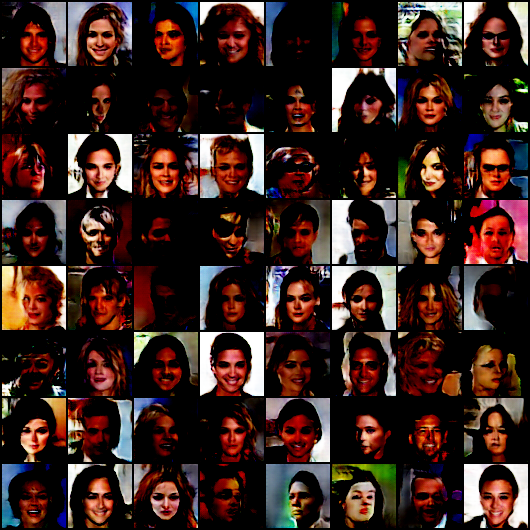

You can check out a GIF animation on how the Generator learns to generate human faces : [GitHub Repo](https://github.com/Vinayak-VG/My-Projects/tree/main/Computer_Vision_Projects/Generative_Adversarial_Networks-GAN/DCGAN)

## **End Note**


Here you go! We have successfully implemented Generative Adversarial Networks. This is a very simple version of GAN( DCGAN ). There has been a lot of advancement in the field of GANs and you can definitely check out the complex models and how they are able to generate high resolution images.

Here's a list of things which you can try it out and experiment

1. StarGAN

2. StackGAN

3. StyleGAN

Problems with GANs: There are a lots of problems while training a GAN. These are a few which come while training a GAN. I would suggest you look up these problems and try to reason out why that may happen and you could refer the internet for solution to the problem :)

1. Mode Collapse: It is the state when the Generator outputs only a same kind of images. Basically it overfits to a very small distribution in the real dataset.

2. Vanishing Gradients
